**Table of contents**<a id='toc0_'></a>    
- [Sources](#toc1_)    
- [Load and import](#toc2_)    
  - [Import libraries](#toc2_1_)    
  - [Load configuration](#toc2_2_)    
  - [Load, split, export data](#toc2_3_)    
- [EDA](#toc3_)    
  - [Classes distribution](#toc3_1_)    
  - [🚧 Constats :](#toc3_2_)    
  - [🚧 Image exploration](#toc3_3_)    
- [Data preprocessing](#toc4_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc5_)    
- [Model Training](#toc6_)    
  - [Load configuration](#toc6_1_)    
- [🚧 MODEL CHOICE](#toc7_)    
  - [Prepare data](#toc7_1_)    
  - [Prepare model](#toc7_2_)    
  - [Training](#toc7_3_)    
  - [Random Baseline](#toc7_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Sources](#toc0_)

https://huggingface.co/datasets/pyronear/pyro-sdis

https://frugalaichallenge.org/participate/

# <a id='toc2_'></a>[Load and import](#toc0_)

## <a id='toc2_1_'></a>[Import libraries](#toc0_)

In [1]:
from datetime import datetime
from fastapi import APIRouter
import logging
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import plotly.express as px
import random
import yaml

# ML
from keras import Model
from keras.applications import EfficientNetB0, EfficientNetV2M
from keras.layers import Flatten, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import AdamW
from keras.utils import image_dataset_from_directory
import numpy as np
import pandas as pd
from scipy.ndimage import median_filter
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf

# Local package libraries
from src.eda import make_autopct
from src.load_data import load_raw_data, clean_df, format_data_keras, oversample_class
from src.models import eval_pretrained_model, ConditionalAugmentation
from tasks.utils.evaluation import ImageEvaluationRequest
from tasks.utils.emissions import tracker, clean_emissions_data, get_space_info
from tasks.image import parse_boxes, compute_iou, compute_max_iou


# Logging outputs config (DEBUG < INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

/Users/julmat/Documents/hugging_face/frugal_cviz/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[codecarbon WARNING @ 23:01:31] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:01:31] [setup] RAM Tracking...
[codecarbon INFO @ 23:01:31] [setup] CPU Tracking...
[codecarbon WARNING @ 23:01:31] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 23:01:31] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 23:01:31] [setup] GPU Tracking...
[codecarbon INFO @ 23:01:31] No GPU found.
[codecarbon INFO @ 23:01:31] >>> Tracker's metadata:
[codecarbon INFO @ 23:01:31]   Platform system: macOS-15.2-arm64-arm-64bit
[codecarbon INFO @ 23

## <a id='toc2_2_'></a>[Load configuration](#toc0_)

In [2]:
# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
# Data
OUTPUT_DIR = cfg["data_root_dir"]
DB_RAW_INFO_URI = os.path.join(OUTPUT_DIR, cfg["db_raw_info_uri"])
DB_KERAS_INFO_URI = os.path.join(OUTPUT_DIR, cfg["db_keras_info_uri"])
DB_AUG_INFO_URI = os.path.join(OUTPUT_DIR, cfg["db_aug_info_uri"])
REPO_ID = cfg["repo_id"]
SPLIT_SIZE = cfg["split_size"]
RDM_SEED = cfg["rdm_seed"]
# Model (common)
MODELS_ROOT_DIR = cfg["models_common"]["models_root_dir"]
CLASSES = cfg["models_common"]["classes"]
LOG_DIR = cfg["models_common"]["log_dir"]
CHKPT_DIR = cfg["models_common"]["chkpts_dir"]

request = ImageEvaluationRequest()

## <a id='toc2_3_'></a>[Load, split, export data](#toc0_)

👉 Load and split data, export in selected format, save DB information in CSV file, delete HF cache folder

In [3]:
df_raw = load_raw_data()

In [4]:
df_raw_train = df_raw.loc[df_raw["split"] == "train"]
df_raw_val = df_raw.loc[df_raw["split"] == "val"]
df_raw_test = df_raw.loc[df_raw["split"] == "test"]

print(
    f"Splits shapes:\nTrain: {df_raw_train.shape}\nVal: {df_raw_val.shape}\nTest: {df_raw_test.shape}\nTOTAL: {df_raw.shape}"
)

Splits shapes:
Train: (23629, 12)
Val: (4099, 12)
Test: (5908, 12)
TOTAL: (33636, 12)


# <a id='toc3_'></a>[EDA](#toc0_)

In [5]:
df_raw

name     label  split  \
0       sdis-07_marguerite-282_2024-01-30T17-01-57.jpg  no_smoke  train   
1      force-06_courmettes-212_2024-01-04T12-06-07.jpg     smoke  train   
2      force-06_courmettes-212_2024-01-16T09-53-11.jpg  no_smoke  train   
3      force-06_courmettes-160_2024-04-26T09-19-42.jpg  no_smoke  train   
4      force-06_courmettes-212_2024-01-12T12-47-33.jpg  no_smoke  train   
...                                                ...       ...    ...   
33631       sdis-07_brison-200_2024-01-04T12-49-23.jpg     smoke   test   
33632       sdis-07_brison-110_2024-03-08T11-23-33.jpg     smoke   test   
33633    sdis-07_marguerite-29_2024-01-31T12-18-29.jpg     smoke   test   
33634    sdis-07_marguerite-29_2024-01-31T09-19-45.jpg     smoke   test   
33635    sdis-07_marguerite-29_2024-03-25T10-11-12.jpg     smoke   test   

      format mode  width  height          camera   partner  \
0       JPEG  RGB   1280     720  marguerite-282   sdis-07   
1       JPEG  RGB   1280     720  courmettes-212  force-06   
2       JPEG  RGB   1280     720  courmettes-212  force-06   
3       JPEG  RGB   1280     720  courmettes-160  force-06   
4       JPEG  RGB   1280     720  courmettes-212  force-06   
...      ...  ...    ...     ...             ...       ...   
33631   JPEG  RGB   1280     720      brison-200   sdis-07   
33632   JPEG  RGB   1280     720      brison-110   sdis-07   
33633   JPEG  RGB   1280     720   marguerite-29   sdis-07   
33634   JPEG  RGB   1280     720   marguerite-29   sdis-07   
33635   JPEG  RGB   1280     720   marguerite-29   sdis-07   

                 timestamp                                        annotations  \
0      2024-01-30T17-01-57                                                NaN   
1      2024-01-04T12-06-07  1 0.109793 0.510421 0.04459380000000002 0.0355...   
2      2024-01-16T09-53-11                                                NaN   
3      2024-04-26T09-19-42                                                NaN   
4      2024-01-12T12-47-33                                                NaN   
...                    ...                                                ...   
33631  2024-01-04T12-49-23  1 0.018262 0.733698 0.0361838 0.05748799999999...   
33632  2024-03-08T11-23-33  1 0.416189 0.647031 0.032136900000000024 0.050...   
33633  2024-01-31T12-18-29  1 0.0340379 0.634492 0.036966 0.05185609999999996   
33634  2024-01-31T09-19-45  1 0.0624102 0.650866 0.035558900000000004 0.03...   
33635  2024-03-25T10-11-12  1 0.794183 0.595804 0.011687299999999956 0.032...   

                                                     uri  
0      data/raw/images/train/sdis-07_marguerite-282_2...  
1      data/raw/images/train/force-06_courmettes-212_...  
2      data/raw/images/train/force-06_courmettes-212_...  
3      data/raw/images/train/force-06_courmettes-160_...  
4      data/raw/images/train/force-06_courmettes-212_...  
...                                                  ...  
33631  data/raw/images/test/sdis-07_brison-200_2024-0...  
33632  data/raw/images/test/sdis-07_brison-110_2024-0...  
33633  data/raw/images/test/sdis-07_marguerite-29_202...  
33634  data/raw/images/test/sdis-07_marguerite-29_202...  
33635  data/raw/images/test/sdis-07_marguerite-29_202...  

[33636 rows x 12 columns]

In [6]:
df_raw.describe(include="all")

name  label  split format  \
count                                            33636  33636  33636  33636   
unique                                           33636      2      3      1   
top     sdis-07_marguerite-282_2024-01-30T17-01-57.jpg  smoke  train   JPEG   
freq                                                 1  28103  23629  33636   
mean                                               NaN    NaN    NaN    NaN   
std                                                NaN    NaN    NaN    NaN   
min                                                NaN    NaN    NaN    NaN   
25%                                                NaN    NaN    NaN    NaN   
50%                                                NaN    NaN    NaN    NaN   
75%                                                NaN    NaN    NaN    NaN   
max                                                NaN    NaN    NaN    NaN   

         mode    width   height      camera  partner            timestamp  \
count   33636  33636.0  33636.0       33636    33636                33636   
unique      1      NaN      NaN          40        3                33464   
top       RGB      NaN      NaN  brison-200  sdis-07  2024-01-20T10-47-07   
freq    33636      NaN      NaN        4971    17766                    3   
mean      NaN   1280.0    720.0         NaN      NaN                  NaN   
std       NaN      0.0      0.0         NaN      NaN                  NaN   
min       NaN   1280.0    720.0         NaN      NaN                  NaN   
25%       NaN   1280.0    720.0         NaN      NaN                  NaN   
50%       NaN   1280.0    720.0         NaN      NaN                  NaN   
75%       NaN   1280.0    720.0         NaN      NaN                  NaN   
max       NaN   1280.0    720.0         NaN      NaN                  NaN   

                                              annotations  \
count                                               28103   
unique                                              27247   
top     1 0.0776863 0.568912 0.029480299999999987 0.08...   
freq                                                    6   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                      uri  
count                                               33636  
unique                                              33636  
top     data/raw/images/train/sdis-07_marguerite-282_2...  
freq                                                    1  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [7]:
df_raw.label.value_counts()

label
smoke       28103
no_smoke     5533
Name: count, dtype: int64

## <a id='toc3_1_'></a>[Classes distribution](#toc0_)

Global

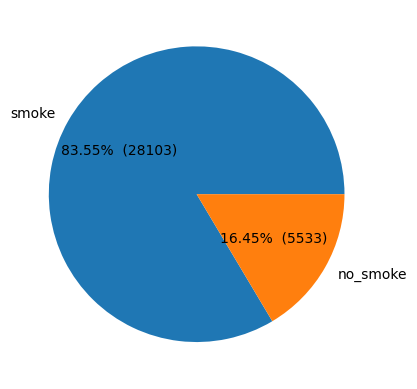

In [8]:
labels_distr = df_raw.label.value_counts()

plt.pie(
    labels_distr,
    labels=labels_distr.index,
    autopct=make_autopct(labels_distr),
)
plt.show()

By split

In [9]:
count_df = df_raw.groupby(["split", "label"]).size().reset_index(name="count")
fig = px.sunburst(count_df, path=["split", "label"], values="count")
fig.update_traces(textinfo="label+percent entry")
fig.show()

Distribution is very unequal: a model **predicting smoke all the time would have an accuracy of 83%**.

Fortunately for firemen, this is not what we want:  
👉 **oversampling the `no_smoke` class with data augmentation is necessary for efficient training**.

> It is to notice that stratification was not used in the challenge base splits, thus this good practice should be considered in future challenges.

## <a id='toc3_2_'></a>[🚧 Constats :](#toc0_)

- 1 seul définition : 1280x720
- 1 seul format : JPG
- 1 seul mode : RGB

- voir répartition des caméras et partenaires selon les splits

## <a id='toc3_3_'></a>[🚧 Image exploration](#toc0_)

name             force-06_courmettes-212_2024-01-16T09-53-11.jpg
label                                                   no_smoke
split                                                      train
format                                                      JPEG
mode                                                         RGB
width                                                       1280
height                                                       720
camera                                            courmettes-212
partner                                                 force-06
timestamp                                    2024-01-16T09-53-11
annotations                                                  NaN
uri            data/raw/images/train/force-06_courmettes-212_...
Name: 2, dtype: object


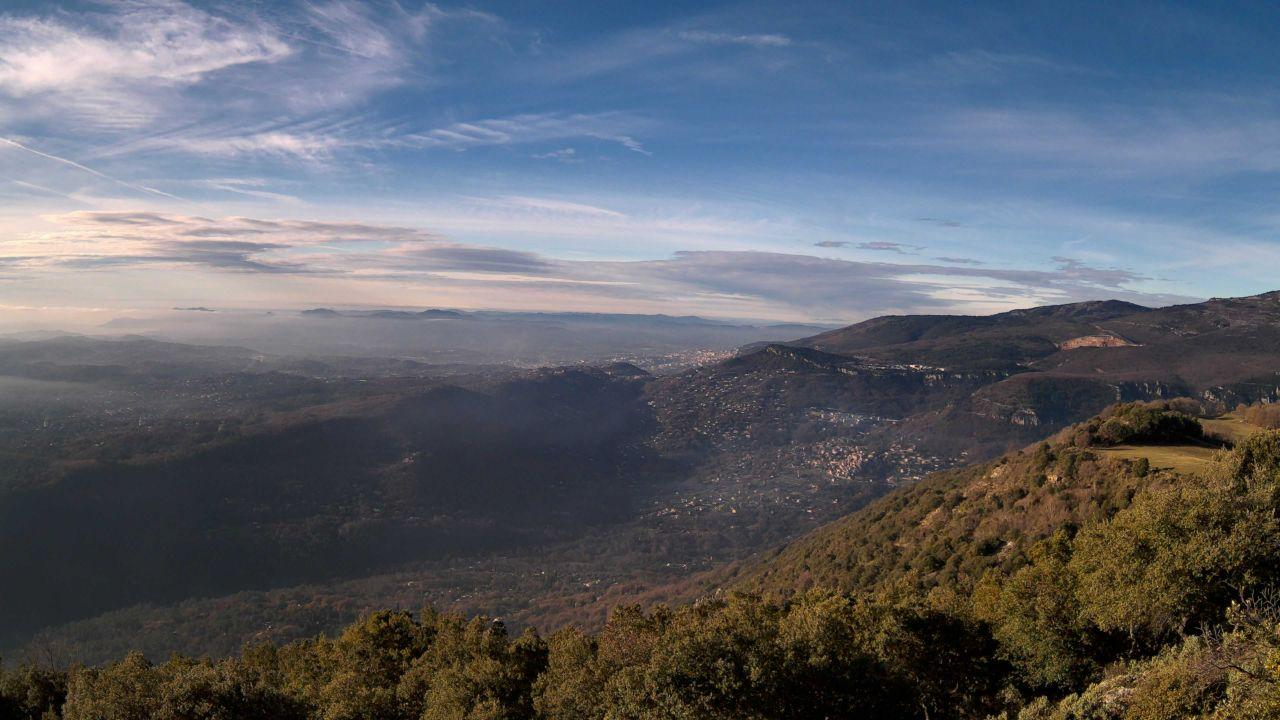

In [10]:
choice = 2

_ = df_raw.loc[choice]
print(_)
img = Image.open(_.uri)
display(img)

# <a id='toc4_'></a>[Data preprocessing](#toc0_)

Clean dataframe: keep necessary data only

In [11]:
df_clean = clean_df(df_raw)

Change data format to chosen model

In [12]:
df_format = format_data_keras(df_clean.copy())

INFO:root:data/data_keras_info.csv already exists: data already formatted


Balance classes by oversampling "no_smoke" label using data augmentation techniques:
- create new images from existing (blur, flip, blur + flip, equalization, 180° rotation)
- update dataframe

> 💡 Much better... but a quality balance issue just appeared: "no_smoke" images are often blured, flipped, equalized or rotated whereas "smoke" images are not.

👉 Following algorithm will oversample and balance classes quality, by applying the same amount of image for the other class

In [13]:
df_aug = oversample_class(df_format)

INFO:root:data/data_aug_info.csv already exists: data already formatted


New classes distribution

In [14]:
count_df = df_aug.groupby(["split", "label"]).size().reset_index(name="count")
fig = px.sunburst(count_df, path=["split", "label"], values="count")
fig.update_traces(textinfo="label+percent entry")
fig.show()

Keep last dataframe as model basis

In [15]:
df = df_aug.copy()

New splits distribution

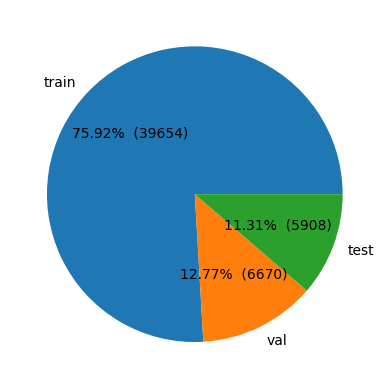

In [16]:
labels_distr = df.split.value_counts()

plt.pie(
    labels_distr,
    labels=labels_distr.index,
    autopct=make_autopct(labels_distr),
)
plt.show()

# <a id='toc6_'></a>[Model Training](#toc0_)

## <a id='toc6_1_'></a>[Load configuration](#toc0_)

# <a id='toc7_'></a>[🚧 MODEL CHOICE](#toc0_)

- https://paperswithcode.com/sota/image-classification-on-imagenet
- https://keras.io/api/applications/efficientnet_v2/#efficientnetv2m-function
- [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit)

# <a id='toc5_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

In [17]:
stop

NameError: name 'stop' is not defined

In [18]:
# Model config
model_name = "EfficientNetV2M"
input_size = (224, 224)
batch_size = 32
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
# model_name = "EfficientNetB0"
# input_size = (224, 224)
# batch_size = 48
# optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
n_epochs = 100
loss = "binary_crossentropy"
metrics = ["accuracy", Precision(), Recall()]
# metrics = ["accuracy", Precision(), Recall(), "f1_score"]

# Input paths
data_dir = os.path.join(OUTPUT_DIR, "keras")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")
# Output paths
MODEL_PATH = os.path.join(MODELS_ROOT_DIR, model_name)
LOG_PATH = os.path.join(MODEL_PATH, LOG_DIR)
CHKPT_PATH = os.path.join(MODEL_PATH, CHKPT_DIR)

## <a id='toc7_2_'></a>[Prepare model](#toc0_)

In [19]:
# Load pre-trained model without top layers
base_model = EfficientNetV2M(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape,
)

# For feature extraction
base_model.trainable = False
# # For partial fine-tuning: freeze bottom layers
# for layer in base_model.layers[:735]:
#     layer.trainable = False

# Create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))

x = base_model(inputs)

# # Dropout for regularization
# x = Dropout(0.2)(x)
# Flatten output
x = Flatten()(x)
# New FC layer for binary classification
predictions = Dense(1, activation="sigmoid")(x)

# Define new model
model_ready = Model(inputs=inputs, outputs=predictions)

# Display model summary
model_ready.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-m            │ (None, 7, 7, 1280)    │ 53,150,388 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 62720)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │     62,721 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 53,213,109 (202.99 MB)

 Trainable params: 62,721 (245.00 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

## <a id='toc7_1_'></a>[Prepare data](#toc0_)

Create datasets from local images and labels

In [20]:
# Prepare for outputs
os.makedirs(MODELS_ROOT_DIR, exist_ok=True)
y = df["label"]
X = df["uri"]

# Create datasets
print("Train dataset:")
train_ds = image_dataset_from_directory(
    train_dir,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=True,  # shuffle images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nVal dataset:")
val_ds = image_dataset_from_directory(
    val_dir,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=True,  # shuffle images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nTest dataset:")
test_ds = image_dataset_from_directory(
    test_dir,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=False,  # do not shuffle images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Train dataset:
Found 39654 files belonging to 2 classes.

Val dataset:
Found 6670 files belonging to 2 classes.

Test dataset:
Found 5908 files belonging to 2 classes.


## <a id='toc7_3_'></a>[Training](#toc0_)

Follow with : `tensorboard --logdir models/EfficientNetB0/runs`

In [101]:
model_trained, history = eval_pretrained_model(
    model=model_ready,
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    LOG_DIR=LOG_PATH,
    CHKPT_DIR=CHKPT_PATH,
    model_name=model_name,
    input_size=input_size,
    batch_size=batch_size,
    n_epochs=n_epochs,
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

INFO:root:⚙️ compiling
INFO:root:🛎️ declaring callbacks
INFO:root:💪 starting training


Epoch 1/100
   7/1240 ━━━━━━━━━━━━━━━━━━━━ 36:58 2s/step - accuracy: 0.4936 - loss: 0.8204 - precision: 0.5297 - recall: 0.5054

In [ ]:
stop

NameError: name 'stop' is not defined

**Training** with Ultralytics YOLO

In [ ]:
# from huggingface_hub import hf_hub_download

# # Correctly set repo_id and repo_type
# repo_id = "pyronear/pyro-sdis"
# filename = "data.yaml"

# # Download data.yaml to the current directory
# yaml_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset", local_dir=".")
# print(f"data.yaml downloaded to: {yaml_path}")

Train with Yolo (command line)

In [ ]:
# yolo task=detect mode=train data=data.yaml model=yolov8n.pt epochs=50 imgsz=640 single_cls=True

## <a id='toc7_4_'></a>[Random Baseline](#toc0_)

In [8]:
# Start tracking emissions
tracker.start()
tracker.start_task("inference")

[codecarbon WARNING @ 17:11:39] Already started tracking
[codecarbon INFO @ 17:11:39] A task is already under measure


# 🚧 INFERENCE

In [ ]:
# import keras
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions
# import numpy as np

# model = ResNet50(weights='imagenet')

# img_path = 'elephant.jpg'
# img = keras.utils.load_img(img_path, target_size=(224, 224))
# x = keras.utils.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# print('Predicted:', decode_predictions(preds, top=3)[0])
# # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]


In [11]:
# --------------------------------------------------------------------------------------------
# YOUR MODEL INFERENCE CODE HERE
# Update the code below to replace the random baseline by your model inference within the inference pass where the energy consumption and emissions are tracked.
# --------------------------------------------------------------------------------------------

# Make random predictions (placeholder for actual model inference)

predictions = []
true_labels = []
pred_boxes = []
true_boxes_list = []  # List of lists, each inner list contains boxes for one image

for example in test_dataset:
    # Parse true annotation (YOLO format: class_id x_center y_center width height)
    annotation = example.get("annotations", "").strip()
    has_smoke = len(annotation) > 0
    true_labels.append(int(has_smoke))

    # Make random classification prediction
    pred_has_smoke = random.random() > 0.5
    predictions.append(int(pred_has_smoke))

    # If there's a true box, parse it and make random box prediction
    if has_smoke:
        # Parse all true boxes from the annotation
        image_true_boxes = parse_boxes(annotation)
        true_boxes_list.append(image_true_boxes)

        # For baseline, make one random box prediction per image
        # In a real model, you might want to predict multiple boxes
        random_box = [
            random.random(),  # x_center
            random.random(),  # y_center
            random.random() * 0.5,  # width (max 0.5)
            random.random() * 0.5,  # height (max 0.5)
        ]
        pred_boxes.append(random_box)


# --------------------------------------------------------------------------------------------
# YOUR MODEL INFERENCE STOPS HERE
# --------------------------------------------------------------------------------------------

In [9]:
# Stop tracking emissions
emissions_data = tracker.stop_task()

[codecarbon WARNING @ 17:12:24] Background scheduler didn't run for a long period (1885s), results might be inaccurate
[codecarbon INFO @ 17:12:24] Energy consumed for RAM : 0.003142 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:12:24] Energy consumed for all CPUs : 0.002618 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 17:12:24] 0.005760 kWh of electricity used since the beginning.


In [12]:
import numpy as np

# Calculate classification metrics
classification_accuracy = accuracy_score(true_labels, predictions)
classification_precision = precision_score(true_labels, predictions)
classification_recall = recall_score(true_labels, predictions)

# Calculate mean IoU for object detection (only for images with smoke)
# For each image, we compute the max IoU between the predicted box and all true boxes
ious = []
for true_boxes, pred_box in zip(true_boxes_list, pred_boxes):
    max_iou = compute_max_iou(true_boxes, pred_box)
    ious.append(max_iou)

mean_iou = float(np.mean(ious)) if ious else 0.0

In [13]:
# Prepare results dictionary
results = {
    "submission_timestamp": datetime.now().isoformat(),
    "classification_accuracy": float(classification_accuracy),
    "classification_precision": float(classification_precision),
    "classification_recall": float(classification_recall),
    "mean_iou": mean_iou,
    "energy_consumed_wh": emissions_data.energy_consumed * 1000,
    "emissions_gco2eq": emissions_data.emissions * 1000,
    "emissions_data": clean_emissions_data(emissions_data),
    "dataset_config": {
        "dataset_name": request.dataset_name,
        "test_size": request.test_size,
        "test_seed": request.test_seed,
    },
}
results

{'submission_timestamp': '2025-01-23T17:13:47.158903',
 'classification_accuracy': 0.4974610697359513,
 'classification_precision': 0.8362892223738063,
 'classification_recall': 0.49625581866019025,
 'mean_iou': 0.0026954029097350594,
 'energy_consumed_wh': 5.759879923426909,
 'emissions_gco2eq': 0.2006914961719638,
 'emissions_data': {'run_id': 'fbab9dd9-2893-4216-91c4-232be358d4dd',
  'duration': 1885.054949500016,
  'emissions': 0.0002006914961719638,
  'emissions_rate': 1.0646457428260931e-07,
  'cpu_power': 5.0,
  'gpu_power': 0.0,
  'ram_power': 6.0,
  'cpu_energy': 0.002618128800231918,
  'gpu_energy': 0,
  'ram_energy': 0.0031417511231949906,
  'energy_consumed': 0.005759879923426909,
  'country_name': 'Switzerland',
  'country_iso_code': 'CHE',
  'region': 'zurich',
  'cloud_provider': '',
  'cloud_region': '',
  'os': 'macOS-15.2-arm64-arm-64bit',
  'python_version': '3.12.7',
  'codecarbon_version': '2.8.3',
  'cpu_count': 8,
  'cpu_model': 'Apple M1',
  'gpu_count': None,
 